### imports

In [2]:
import time
import os
from random import randrange

import pickle
import tensorflow as tf
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from tensorflow.keras import Input, Model, Sequential, layers, losses, optimizers, initializers, applications, utils
import tensorflow_text as text
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

### helper functions

In [3]:
def format_time(seconds):
    """
        Formats time in seconds to h:mm:ss.
    """
    return "{}:{:0>2}:{:0>2}".format(int(seconds//3600), int((seconds//60)%60), int(seconds%60))

### prepare data

In [4]:
inputs, labels = [], []
classnames = []

# create inputs
for file in os.listdir('dataset'):
    with open('dataset/' + file) as f:
        inputs.extend(f.read().splitlines())
        classnames.append(file.split('.')[0])

# get classes
classnames = list(set(classnames))

# create labels for each input
for file in os.listdir('dataset'):
    with open('dataset/' + file) as f:
        classname = file.split('.')[0]
        for line in f:
            labels.append(classnames.index(classname))

batch_size = 5
inputs = np.array(inputs)
inputs = np.reshape(inputs, [-1, batch_size])
labels = np.array(labels)
labels = np.reshape(labels, [-1, batch_size])

test_inputs, test_labels = [], []

# create test inputs/labels
for file in os.listdir('testset'):
    with open('testset/' + file) as f:
        lines = f.read().splitlines()
        test_inputs.extend(lines)
        classname = file.split('.')[0]
        for line in lines:
            test_labels.append(classnames.index(classname))

test_batch_size = 5
test_inputs = np.array(test_inputs)
test_inputs = np.reshape(test_inputs, [-1, test_batch_size])
test_labels = np.array(test_labels)
test_labels = np.reshape(test_labels, [-1, test_batch_size])

### create model

In [5]:
text_input = layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2", trainable=True)
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
output = layers.Dense(len(classnames), activation='softmax')(pooled_output)
model = Model(inputs=text_input, outputs=output)
# model.summary()
embedding_model = Model(inputs=text_input, outputs=pooled_output)
# embedding_model.summary()

### run model

In [6]:
def infer():
    idx = randrange(test_inputs.shape[0])
    x, y = test_inputs[idx], test_labels[idx]

    # get predictions
    y_hat = model(x)
    y_hat = np.argmax(y_hat, axis=1)

    # print input, predictions, labels
    for i in range(test_batch_size):
        print(f"Input: {x[i]}")
        print(f"Predicted label: {classnames[y_hat[i]]}")
        print(f"Actual label: {classnames[y[i]]}\n")

### training loop

In [ ]:
lr = 5e-5
optimizer = optimizers.Adam(learning_rate=lr)
@tf.function(input_signature=[
    tf.TensorSpec(shape=(None), dtype=tf.string),
    tf.TensorSpec(shape=(None), dtype=tf.int32)
])
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = losses.sparse_categorical_crossentropy(y, y_hat)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

### train model

In [ ]:
def train(num_epochs=50):
    loss_history = []
    prev_time = time.time()
    time_elapsed = 0

    # load saved models
    if os.path.isfile("models/topic-model.h5"):
        model.load_weights("models/topic-model.h5")

    print("Training...")

    for epoch in range(num_epochs):
        loss_this_epoch = []
        for x, y in tqdm(zip(inputs, labels), total=len(inputs)):
            loss = train_step(x, y)
            loss_this_epoch.append(loss.numpy().mean())

            time_elapsed += time.time() - prev_time
            prev_time = time.time()

        loss_history.append(sum(loss_this_epoch) / len(loss_this_epoch))
        print(f"Epoch {epoch + 1}/{num_epochs}. Loss: {sum(loss_this_epoch) / len(loss_this_epoch)}. Time elapsed: {format_time(time_elapsed)}\n")
        # save checkpoints
        model.save_weights("models/topic-model.h5")
        model.save_weights(f"models/weights{epoch + 1}.h5")

        infer()

        # plot a graph that will show how our loss varied with time
        plt.plot(loss_history)
        plt.title("Training Progress")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.savefig(os.path.join("./plots", "Training Progress"))
        # plt.show()
        plt.close()

train()

### load model weights

In [7]:
# load the weights into the model
model.load_weights("models/weights48.h5")

# transfer the weights from the model to the embedding model layer b
for i in range(len(embedding_model.layers)):
    embedding_model.layers[i].set_weights(model.layers[i].get_weights())

### save model

In [6]:
# save embedding model to pb file
embedding_model.save("models/BERT/1/")

INFO:tensorflow:Assets written to: models/BERT/1/assets


INFO:tensorflow:Assets written to: models/BERT/1/assets


### get embeddings

In [8]:
def get_embeddings(statement):
    embedding = embedding_model(tf.constant([statement])).numpy().squeeze()
    return embedding

### get clusters of training data

100%|██████████| 21/21 [00:04<00:00,  4.98it/s]
C:\Users\Moses\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Moses\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


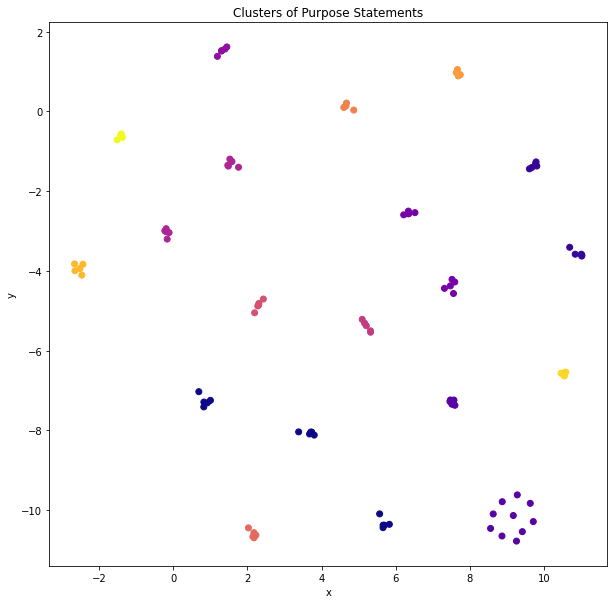

In [9]:
# for the training set, create a dictionary with the text as the key and the embeddings as the value
train_embeddings = {}
for x, y in tqdm(zip(inputs, labels), total=len(inputs)):
    for i in range(batch_size):
        train_embeddings[x[i]] = get_embeddings(x[i])

purpose_statements = list(train_embeddings.keys())
embeddings = np.vstack(list(train_embeddings.values()))

# Compute the covariance matrix of the data
cov_matrix = np.cov(embeddings.T)

# Perform eigenvalue decomposition on the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues in decreasing order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# Look for the elbow in the plot to estimate the number of clusters
# In this example, we'll use the number of clusters corresponding to the first significant drop in eigenvalue
n_clusters = 0
for i in range(len(eigenvalues)):
    if eigenvalues[i] < eigenvalues[0] * 0.1:
        n_clusters = i
        break

if n_clusters == 0:
    n_clusters = len(eigenvalues)

agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average', compute_distances=True)
agg_cluster.fit(embeddings)
cluster_labels = agg_cluster.labels_

# Calculate cluster centroids as mean of embeddings in each cluster
centroids = np.zeros((n_clusters, embeddings.shape[1]))

for i in range(n_clusters):
    cluster_embeddings = np.vstack([train_embeddings[ps] for j, ps in enumerate(purpose_statements) if cluster_labels[j] == i])
    centroids[i] = np.mean(cluster_embeddings, axis=0)

# visualize the clusters
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='plasma')
plt.title("Clusters of Purpose Statements")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


### save training set embeddings

In [ ]:
# Save embeddings to file
grouped_embeddings = {}
for i in range(n_clusters):
    cluster_i = np.stack([emb for j, emb in enumerate(embeddings) if cluster_labels[j] == i])
    label_i = i
    if cluster_i.shape[0] > 0:
        grouped_embeddings[str(label_i)] = cluster_i

print(grouped_embeddings)
np.savez("./server/assets/train_embeddings.npz", **grouped_embeddings)
grouped_embeddings = dict(np.load("./server/assets/train_embeddings.npz"))

### save the clustering model to a file

In [36]:
# Save the clustering model to a file
with open('./server/assets/cluster_model.pkl', 'wb') as f:
    pickle.dump(agg_cluster, f)

### show the contents of clusters

In [10]:
# Print purpose statements in each cluster
for i in range(n_clusters):
    cluster_i = [ps for j, ps in enumerate(purpose_statements) if cluster_labels[j] == i]
    print(f"Cluster {i}: {cluster_i}")

Cluster 0: ['To promote access to quality education for all individuals, regardless of socioeconomic background, race, or gender, in order to foster a more equitable and just society.', 'To promote teacher development and training programs that improve instructional practices and promote effective teaching strategies, in order to enhance student learning outcomes and promote a culture of lifelong learning.', 'To advocate for policies and regulations that promote equitable and adequate funding for public schools, in order to reduce educational disparities and promote equal access to quality education.', 'To promote education for sustainable development, which integrates principles of environmental sustainability and social responsibility into educational curricula and programs, in order to develop environmentally and socially conscious citizens.', 'To promote intercultural understanding and global citizenship by providing opportunities for students to learn about and engage with diverse

### get the cluster of a new statement

In [35]:
new_statement = "To promote responsible and ethical use of technology by developing digital solutions that are transparent, secure, and protect user privacy, and by advocating for policies that ensure technology benefits society as a whole."
new_embedding = get_embeddings(new_statement)

# Calculate distances between new user embedding and cluster centroids
distances = pairwise_distances(new_embedding.reshape(1, -1), centroids, metric='cosine')

# Calculate distribution of distances
distances_hist, distances_bins = np.histogram(distances, bins=100)

# Find elbow point of distribution
distances_cumsum = np.cumsum(distances_hist)
total_distance = distances_cumsum[-1]
distance_ratios = distances_cumsum / total_distance
elbow_idx = np.argmax(distance_ratios > 0.9)

# Choose threshold based on elbow point
threshold = distances_bins[elbow_idx]

# Find the index of the closest cluster
closest_cluster_idx = np.argmin(distances)

# Check if distance is below threshold, otherwise create new cluster
if distances[0, closest_cluster_idx] < threshold:
    # Assign new user to closest cluster
    new_label = closest_cluster_idx
else:
    # Create new cluster for new user
    new_label = len(centroids)
    centroids = np.vstack([centroids, new_embedding])
    cluster_labels = np.append(cluster_labels, new_label)

print(f"New label: {new_label}")

New label: 4
